In [40]:
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path.cwd().parent.joinpath('data', 'raw', 'market_values.csv')

In [3]:
market_values = pd.read_csv(DATA_PATH, usecols=
                            [
                                'fyearq', 'fqtr', 'fyr', 'indfmt', 'consol', 'popsrc',
                                'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr',
                                'exchg', 'costat', 'fic', 'mkvaltq'
                            ]
                           )

In [4]:
market_values.head()

,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,conm,curcdq,datacqtr,datafqtr,exchg,costat,fic,mkvaltq
0,2000,1.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q1,2000Q1,11,I,USA,NaN
1,2000,2.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q2,2000Q2,11,I,USA,NaN
2,2000,3.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q3,2000Q3,11,I,USA,NaN
3,2000,4.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2000Q4,2000Q4,11,I,USA,NaN
4,2001,1.0,12,INDL,C,D,STD,ABF,AIRBORNE INC,USD,2001Q1,2001Q1,11,I,USA,NaN


<AxesSubplot:>

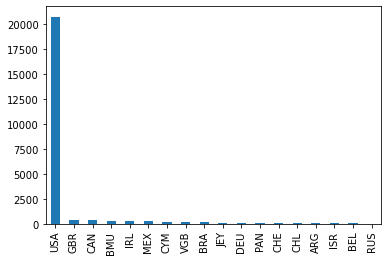

In [5]:
market_values.fic.value_counts().plot(kind='bar')

In [43]:
bad_data = list()
for ticker in market_values.tic.unique():
    subset = market_values[market_values.tic==ticker]
    current = 'na' if np.isnan(subset.mkvaltq.iloc[0]) else 'val'
    for v in subset.mkvaltq[1:]:
        if not np.isnan(v):
            current = 'val'
        elif current == 'val' and np.isnan(v):
            bad_data.append((ticker, subset.conm.iloc[0]))
            continue

In [44]:
Counter(bad_data)

Counter({('DAN', 'DANA INC'): 1,
         ('DG', 'DOLLAR GENERAL CORP'): 10,
         ('GM', 'GENERAL MOTORS CO'): 1,
         ('KHC', 'KRAFT HEINZ CO'): 10,
         ('LZB', 'LA-Z-BOY INC'): 1,
         ('JEF', 'JEFFERIES FINANCIAL GRP INC'): 1,
         ('NATR', 'NATURES SUNSHINE PRODS INC'): 4,
         ('CCL', 'CARNIVAL CORPORATION & PLC'): 5,
         ('NBEV', 'NEWAGE INC'): 2,
         ('SMPL', 'SIMPLY GOOD FOODS COMPANY'): 5,
         ('PFGC', 'PERFORMANCE FOOD GROUP CO'): 32,
         ('KDP', 'KEURIG DR PEPPER INC'): 10,
         ('LMNR', 'LIMONEIRA CO'): 4,
         ('BTH', 'BLYTH INC'): 1,
         ('BEAM', 'BEAM THERAPEUTICS INC'): 1,
         ('NHTC', 'NATURAL HEALTH TRENDS CORP'): 3,
         ('JAKK', 'JAKKS PACIFIC INC'): 1,
         ('TTWO', 'TAKE-TWO INTERACTIVE SFTWR'): 2,
         ('AIPC', 'AMER ITALIAN PASTA CO  -CL A'): 3,
         ('SVM', 'SILVERCORP METALS INC'): 4,
         ('APTV', 'APTIV PLC'): 9,
         ('SEED', 'ORIGIN AGRITECH LTD'): 7,
         ('CELH', '